In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [49]:
from src.dataset import load_team_data, load_agg_player_data
from src.preprocessing import impute_missing_values, split_data, remove_name_columns, encode_target_variable, remove_na_columns, find_knee_point

team_statistics, y = load_team_data()
player_statistics = load_agg_player_data()
x = pd.concat([team_statistics, player_statistics], axis=1, join='inner')

x = remove_name_columns(x)
y = encode_target_variable(y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(x, y)

x_train, imputer, numeric_columns = impute_missing_values(x_train)
x_val, _, _ = impute_missing_values(x_val, imputer=imputer, numeric_columns=numeric_columns)
x_test, _, _ = impute_missing_values(x_test, imputer=imputer, numeric_columns=numeric_columns)

x_train, non_na_columns = remove_na_columns(x_train)
x_val, _ = remove_na_columns(x_val, non_na_columns=non_na_columns)
x_test, _ = remove_na_columns(x_test, non_na_columns=non_na_columns)

y_train = y_train.to_numpy().flatten()
y_val = y_val.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

In [50]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# === Compute mutual information between features and target variable ===
scores = mutual_info_regression(x_train, y_train)


order = np.argsort(scores)[::-1]
scores_sorted = scores[order]

k = 10
knee_indices = [find_knee_point(scores_sorted)]

for i in range(k-1):
    knee_indices.append(find_knee_point(scores_sorted[knee_indices[i]:]) + knee_indices[i])
# =======================================================================

# === Extract best features ===
index_knee = 3
columns_selected = x_train.columns[order[:knee_indices[index_knee]]]

features = list(columns_selected)
features = set([feature[5:] for feature in features])

columns_to_keep = ["HOME_" + feature for feature in features] + ["AWAY_" + feature for feature in features]

x_train = x_train[columns_to_keep]
x_val = x_val[columns_to_keep]
x_test = x_test[columns_to_keep]
# =============================

# === Define model parameters ===
l1_ratio = 0.5
C = 1
multi_class = "auto"
# ===============================

# === Train model ===
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=l1_ratio, C=C, max_iter=2000, multi_class=multi_class, random_state=42)
model.fit(x_train, y_train)

LogisticRegression(C=1, l1_ratio=0.5, max_iter=2000, penalty='elasticnet',
                   random_state=42, solver='saga')

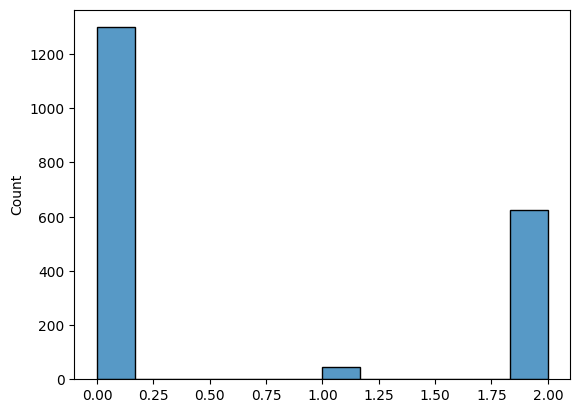

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(model.predict(x_val))
plt.show()

In [55]:
import numpy as np

team_statistics, y = load_team_data()
player_statistics = load_agg_player_data()
x = pd.concat([team_statistics, player_statistics], axis=1, join='inner')

x = remove_name_columns(x)
y = encode_target_variable(y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(x, y)

x_train, imputer, numeric_columns = impute_missing_values(x_train)
x_val, _, _ = impute_missing_values(x_val, imputer=imputer, numeric_columns=numeric_columns)
x_test, _, _ = impute_missing_values(x_test, imputer=imputer, numeric_columns=numeric_columns)

x_train, non_na_columns = remove_na_columns(x_train)
x_val, _ = remove_na_columns(x_val, non_na_columns=non_na_columns)
x_test, _ = remove_na_columns(x_test, non_na_columns=non_na_columns)

y_train = y_train.to_numpy().flatten()
y_val = y_val.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

scores = mutual_info_regression(x_train, y_train)
np.save("features_importance_mutual_info_based.npy", scores)